# GA Users Workshop

Clean and play around with transcripts . Author: A.Pilko <A.Pilko@soton.ac.uk>

In [101]:
# Install deps
!pip3 install nltk pandas stopwordsiso matplotlib gensim pyLDAvis python-Levenshtein
import nltk
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import gensim
import pyLDAvis
import stopwordsiso as swiso
from copy import deepcopy

%matplotlib notebook

# Why is this not default..
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set a date otherwise conversion to datetime dtype reverts to current date
date_str = '2021-03-26 '

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Ingest

In [2]:
chat_token_split_regex = re.compile(r'\[.*?\].*?\s*?.\d{2}:\d{2}(?::\d{2})?')
trans_token_split_regex = re.compile(r'\d{2}:\d{2}:\d{2}')

msg_regex = re.compile(r'(?<=]).*?(?=\s+.\d{2}:\d{2}(?::\d{2})?)')
ts_regex = re.compile(r'\s*?\d{2}:\d{2}(?::\d{2})?')
author_regex = re.compile(r'\[.*?\]')

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Chat

In [3]:
with open('cleaned_chat.txt', 'r') as f:
    raw_chat = f.read()

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokenise chat messages by regex and extract author and time

In [4]:
# Get individual chat msgs
chat_tokens = chat_token_split_regex.findall(raw_chat)
chat_tokens = [m.strip() for m in chat_tokens if m and m.strip()] # Filter nulls and strip control chars
print(len(chat_tokens), ' chat messages ')
chat_tokens[-10:] # Print first 10 for sanity check

412  chat messages 


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['[GA Pilot 6] Thanks for consulting us - a big step in the right direction.\n\t11:01',
 '[Drone Industry Interest 4] How do we get in touch with the APPG @nouj?\n\t11:01',
 '[GA Pilot 31] Thank you, Jim, panel & Facilitator\n\t11:01',
 '[GA Pilot 3] Engagement t is difficult but worthwhile thank you for the opportunity .\n\t11:01',
 '[GA Pilot 33] Thanks very good discussion\n\t11:01',
 '[Model Aircraft Flyer] Thanks. Well chaired [Facilitator] \n\t11:02',
 '[GA Pilot 17] Keep talking, continuing communication is essential\n\t11:02',
 '[Drone User 8] Thanks for hosting. It was really smooth. Perhaps next time an additional 30mins for the whiteboard sessions\n\t11:02',
 "[GA Pilot 35] As Chair of the Local to Ipswich LAA Club the Great Oakley ACP stimulated a response from our members - thank you for the engagement and more is required!! - this is about 'change' and stakeholder engagement really important\n\t11:02",
 '[GA Pilot 6] Well managed, [Facilitator]. Thanks.\n\t11:02']

In [5]:
chat_authors = [author_regex.match(m).group(0).strip('[]') for m in chat_tokens]

assert len(chat_authors) == len(chat_tokens) # or something has gone very wrong...
print(len(set(chat_authors)), ' unique chat authors ')
chat_authors[:10] # SC

52  unique chat authors 


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Microlight pilot 6',
 'R and D 3',
 'Facilitator',
 'GA Pilot 23',
 'Facilitator',
 'Microlight pilot 7',
 'GA Pilot 18',
 'GA Pilot 30',
 'GA Pilot 3',
 'GA Pilot 18']

In [6]:
chat_timestamps = [date_str + ts_regex.search(m).group(0).strip() for m in chat_tokens]

assert len(chat_timestamps) == len(chat_tokens)
chat_timestamps[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['2021-03-26 09:07',
 '2021-03-26 09:08',
 '2021-03-26 09:09',
 '2021-03-26 09:19',
 '2021-03-26 09:21',
 '2021-03-26 09:22',
 '2021-03-26 09:23',
 '2021-03-26 09:23',
 '2021-03-26 09:25',
 '2021-03-26 09:25']

In [7]:
chat_msgs = [msg_regex.search(m).group(0).strip() for m in chat_tokens]
assert len(chat_msgs) == len(chat_tokens)
chat_msgs[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Will the slides be shared',
 'Ooo yes please. I would like to share them with my PDRA at the University of Edinburgh who is working on the UKRI TAS Governance node.',
 'Yes, slides will be shared after the workshop',
 'How many transits between Lee-on-Solent and Binstead were completed during the trial?',
 'Thanks Jonathan, weâ€™ll return to that during questions',
 'Statement of needs often downplay alternates. Hovercraft transit about the same time. Importantly what are drone weather limitations? Vans and ferry will operate in all weathers - Skyports Oban trial said they couldnt operate 40% of time due wind so have extended trial. Important issue.',
 'Lots of demand when there is no cost to users and government grants paying providers',
 'where is the "demand" from ? There does not appear to have been a business case published for any TDA examining the drone versus alternates',
 'UTM in 5 years is very ambitious',
 'You need autonomous detect and avoid certified for every BVLOS dro

Pile in all parsed out chat data into dataframe

In [8]:
chat_df = pd.DataFrame({'author': chat_authors, 'time': chat_timestamps, 'message': chat_msgs})
chat_df['author'] = chat_df['author'].astype('string')
chat_df['time'] = pd.to_datetime(chat_df['time'])
chat_df['message'] = chat_df['message'].astype('string')
print(chat_df.dtypes)
chat_df.head()

author             string
time       datetime64[ns]
message            string
dtype: object


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,time,message
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...
2,Facilitator,2021-03-26 09:09:00,"Yes, slides will be shared after the workshop"
3,GA Pilot 23,2021-03-26 09:19:00,How many transits between Lee-on-Solent and Bi...
4,Facilitator,2021-03-26 09:21:00,"Thanks Jonathan, weâ€™ll return to that during..."


### Presentation Transcript

In [9]:
with open('cleaned_transcript.txt', 'r') as f:
    raw_trans = f.read()

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Get timestamped blocks in transcript
ts_tokens = trans_token_split_regex.split(raw_trans)
ts_tokens = [m.strip() for m in ts_tokens if m and m.strip()] # Filter nulls and strip control chars
print(len(ts_tokens), ' transcript timeblocks ')
_ = [print(t, end='\n--------------------------------------------------------------------\n') for t in ts_tokens] # Print first 10 for sanity check

97  transcript timeblocks 
[Facilitator] Welcome everybody. We are just waiting for some remaining people to join the call as we near nine o'clock. So, we're going to leave a couple of minutes now just to allow any last people to come through and then we'll be making a start within two or three minutes.  

Thank you so much for being here with us. And we will have a proper introduction in just a moment.  And to be clear, this is the workshop on un-crewed aerial vehicles in shared airspace, you are in the right place. Weâ€™ll be making a start up in just a couple of minutes.  We've still got some people arriving, so we'll just allow them to come through and then we'll make a start.

And just a note to everybody, I am using the control to mute all participants just to make sure that we don't simultaneously hear about 60 people who've tapping away at the same time.  If at any point you want to contribute, you will need to unmute yourself, which should be available via the microphone icon,

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# ts_timestamps = [ts_regex.search(m).group(0).strip() for m in ts_tokens]
ts_timestamps = [date_str + t.strip() for t in trans_token_split_regex.findall(raw_trans)][:-1]
for t in ts_timestamps:
    if ts_timestamps.count(t) > 1:
        print(t)

print(len(ts_timestamps))
# assert len(ts_timestamps) == len(ts_tokens)
ts_timestamps[:10]

97


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['2021-03-26 09:00:40',
 '2021-03-26 09:06:50',
 '2021-03-26 09:07:21',
 '2021-03-26 09:09:46',
 '2021-03-26 09:12:19',
 '2021-03-26 09:13:54',
 '2021-03-26 09:15:30',
 '2021-03-26 09:16:16',
 '2021-03-26 09:16:50',
 '2021-03-26 09:17:53']

In [12]:
# Here not all transcribed messages have an author attached as the timestamps are thrown in the middle of text.
# This presumes the previously tagged author is still talking

ts_authors = []
for m in ts_tokens:
    ssm = author_regex.match(m)
    if ssm:
        ts_authors.append(ssm.group(0).strip('[]'))
    else:
        ts_authors.append(ts_authors[-1])

assert len(ts_authors) == len(ts_tokens)
print(len(set(ts_authors)), ' unique transcript authors ')
set(ts_authors) # SC

10  unique transcript authors 


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Drone User 2',
 'Facilitator',
 'GA Pilot 1',
 'GA Pilot 36',
 'GM',
 'JS',
 'Microlight Pilot 2',
 'NJ',
 'Other 1',
 'TC'}

In [13]:
ts_msgs = [author_regex.sub('', m) for m in ts_tokens]

assert len(ts_msgs) == len(ts_tokens)
ts_msgs[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[" Welcome everybody. We are just waiting for some remaining people to join the call as we near nine o'clock. So, we're going to leave a couple of minutes now just to allow any last people to come through and then we'll be making a start within two or three minutes.  \n\nThank you so much for being here with us. And we will have a proper introduction in just a moment.  And to be clear, this is the workshop on un-crewed aerial vehicles in shared airspace, you are in the right place. Weâ€™ll be making a start up in just a couple of minutes.  We've still got some people arriving, so we'll just allow them to come through and then we'll make a start.\n\nAnd just a note to everybody, I am using the control to mute all participants just to make sure that we don't simultaneously hear about 60 people who've tapping away at the same time.  If at any point you want to contribute, you will need to unmute yourself, which should be available via the microphone icon, which is on the left most side of

In [14]:
trans_df = pd.DataFrame({'author': ts_authors, 'time': ts_timestamps, 'message': ts_msgs})
trans_df['author'] = trans_df['author'].astype('string')
trans_df['time'] = pd.to_datetime(trans_df['time'])
trans_df['message'] = trans_df['message'].astype('string')
print(trans_df.dtypes)
trans_df.head()

author             string
time       datetime64[ns]
message            string
dtype: object


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,time,message
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ..."
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherr..."
3,TC,2021-03-26 09:09:46,"Next slide, please. Just to introduce you to t..."
4,TC,2021-03-26 09:12:19,"Next slide, please. Just a little bit of back..."


In [15]:
full_df = pd.concat((chat_df, trans_df)).sort_values('time')
full_df.to_csv('interlaced_transcript.csv')
print(full_df.dtypes)
full_df.head()

author             string
time       datetime64[ns]
message            string
dtype: object


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,time,message
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ..."
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherr..."
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...


At this point, the raw text is tagged with relevant metadata and in a form that is easy to work with. It is, however, still verbatim and contains shedloads of extraneous words etc. This is cleaned next.

## Sentiment Analysis

Strip punctuation, extra whitespace, normalise case. Homogenous text is then tokenised into words, stopwords (eg I, he, she, was, the) are removed then words are lemmatised (taken to root form, eg "going" and "gone" stem from "go")

In [16]:
custom_stopwords = {
    'chat', 'please', 'jim', 'project', 'slide', 'shared', 'janet', 'morning', 'ooo', 'yeah', 'please', 'share', 'facilitator',
    'tom', 'cherrett', 'pdra', 'edinburgh', 'node', 'ta', 'unmute', 'mute', 'hear', 'tapping', 'time', 'bar', 'icon', 'microphone',
    'device', 'icon', 'bar', 'visible', 'screen', 'hover', 'mouse', 'selection', 'icon', 'mobile', 'device', 'browser', 'version',
    'zoom', 'select', 'dot', 'aliaksei', 'pilko', 'nick', 'jelev', 'german', 'moreno', 'dickinson', 'matt', 'grote', 'phd', 'researcher',
    'dr', 'bournemouth', 'management', 'professor', 'scanlan', 'waiting', 'remaining', 'people', 'clock', 'leave', 'couple', 'minute',
    'start', 'proper', 'introduction', 'moment', 'workshop', 'arriving', 'note', 'control', 'participant', 'simultaneously', 'contribute',
    'depending', 'reiterate', 'thumb', 'team', 'attending', 'finding', 'straightforward', 'frustration', 'hearing', 'colleague', 'presentation',
    'explaining', 'background', 'quick', 'housekeeping', 'purpose', 'record', 'view', 'signed', 'eventbrite', 'received', 'sheet', 'consenting',
    'participating', 'exit', 'commitment', 'recorded', 'internal', 'data', 'anonymised', 'output', 'agreeing', 'consent', 'outline', 'chance',
    'heard', 'limitation', 'invite', 'accessible', 'mentioned', 'speech', 'labelled', 'type', 'response', 'option', 'private', 'messaging',
    'submission', 'blue', 'list', 'send', 'message', 'rest', 'comment', 'question', 'return', 'leaving', 'initial', 'clarified', 'ensure',
    'covered', 'simply', 'speak', 'clicking', 'reaction', 'smiley', 'raise', 'hand', 'picture', 'sound', 'track', 'fine', 'cover',
    'clarification', 'ado', 'introduce', 'listen', 'receive', 'user', 'online', 'lot'
}

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
punc_regex = re.compile('[^0-9A-Za-z ]')
xws_regex = re.compile('\s+', flags=re.MULTILINE)

nltk.download('punkt')
tok = nltk.tokenize.word_tokenize

# Common stop words plus some custom ones that appear commonly here but are not relevant
sws = swiso.stopwords('en') | custom_stopwords

nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def _clean_msg(msg):
    res = xws_regex.sub(' ', msg) # Strip extra whitespace
    res = punc_regex.sub(' ', msg) # Strip Punctuation
    res = res.lower() # Force lowercase
    tokens = [t for t in tok(res) if t not in sws and not t.isdigit()] # Tokenise into words
    lemmas = [wn.lemmatize(t) for t in tokens] #Lemmatise
    return [l for l in lemmas if l not in sws and not t.isdigit()] # recheck lemmas for stopwords and return
    
clean_df = deepcopy(full_df)
clean_df['tokens'] = clean_df['message'].apply(_clean_msg)
clean_df['message'] = [m.replace('\n', '') for m in clean_df['message']]
clean_df.head()

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-17-d9bc425fec0a>:2: DeprecationWarning: invalid escape sequence \s
  xws_regex = re.compile('\s+', flags=re.MULTILINE)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aliak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aliak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

,author,time,message,tokens
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...,"[crewed, aerial, vehicle, airspace, left, casc..."
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ...","[recreational, airspace, managing, drone, airs..."
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared,[]
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherret...","[head, transportation, university, southampton..."
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...,"[university, ukri, governance]"


In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
nltk.download('vader_lexicon')

sa = SentimentIntensityAnalyzer()

clean_df['compound_sentiment'] = [sa.polarity_scores(m)['compound'] for m in clean_df['message']]
clean_df.head()

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aliak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

,author,time,message,tokens,compound_sentiment
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...,"[crewed, aerial, vehicle, airspace, left, casc...",0.9992
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ...","[recreational, airspace, managing, drone, airs...",0.9732
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared,[],0.3400
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherret...","[head, transportation, university, southampton...",0.9834
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...,"[university, ukri, governance]",0.8271


Split transcript into what we said("internal") and comments from attendees ("external")

In [19]:
internal_authors = ['Facilitator', 'TC', 'JS', 'NJ', 'GM', 'AP', 'MG']

int_df = clean_df[clean_df['author'].isin(internal_authors)]
ext_df = clean_df[~clean_df['author'].isin(internal_authors)]
int_df.head()
ext_df.head()
int_tokens = nltk.flatten(int_df['tokens'].tolist())
ext_tokens = nltk.flatten(ext_df['tokens'].tolist())
print(len(set(int_tokens)), ' unique internal tokens')
print(len(set(ext_tokens)), ' unique external tokens')

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,time,message,tokens,compound_sentiment
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...,"[crewed, aerial, vehicle, airspace, left, casc...",0.9992
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ...","[recreational, airspace, managing, drone, airs...",0.9732
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherret...","[head, transportation, university, southampton...",0.9834
2,Facilitator,2021-03-26 09:09:00,"Yes, slides will be shared after the workshop",[],0.6249
3,TC,2021-03-26 09:09:46,"Next slide, please. Just to introduce you to t...","[based, faculty, university, experience, publi...",0.9857


,author,time,message,tokens,compound_sentiment
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared,[],0.3400
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...,"[university, ukri, governance]",0.8271
3,GA Pilot 23,2021-03-26 09:19:00,How many transits between Lee-on-Solent and Bi...,"[transit, lee, solent, binstead, completed, tr...",0.0000
5,Microlight pilot 7,2021-03-26 09:22:00,Statement of needs often downplay alternates. ...,"[statement, downplay, alternate, hovercraft, t...",0.4767
6,GA Pilot 18,2021-03-26 09:23:00,Lots of demand when there is no cost to users ...,"[demand, cost, government, grant, paying, prov...",-0.2023


1181  unique internal tokens
1235  unique external tokens


In [20]:
int_freqdist = nltk.FreqDist(int_tokens)
ext_freqdist = nltk.FreqDist(ext_tokens)
print('Top 10 Internal:')
int_freqdist.tabulate(12)
print('\nTop 10 External:')
ext_freqdist.tabulate(12)

Top 10 Internal:
     drone   airspace      issue      class       lima   aircraft       term      board        air university      space       idea 
        79         51         41         40         31         26         23         23         22         21         20         20 

Top 10 External:
   drone    class    pilot airspace    avoid aircraft      tmz      tda     lima solution      caa operator 
     107       72       71       67       38       35       33       24       24       24       23       21 


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
ewma_smoothing = 0.16

int_df['cs_ewma'] = int_df['compound_sentiment'].ewm(alpha=ewma_smoothing).mean()
ext_df['cs_ewma'] = ext_df['compound_sentiment'].ewm(alpha=ewma_smoothing).mean()

int_df.head()
ext_df.head()

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-21-2ed1d5c34984>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_df['cs_ewma'] = int_df['compound_sentiment'].ewm(alpha=ewma_smoothing).mean()
<ipython-input-21-2ed1d5c34984>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,author,time,message,tokens,compound_sentiment,cs_ewma
0,Facilitator,2021-03-26 09:00:40,Welcome everybody. We are just waiting for so...,"[crewed, aerial, vehicle, airspace, left, casc...",0.9992,0.999200
1,TC,2021-03-26 09:06:50,"Thanks very much, . Good morning, everyone. ...","[recreational, airspace, managing, drone, airs...",0.9732,0.985070
2,TC,2021-03-26 09:07:21,"Next slide, please. So, my name is Tom Cherret...","[head, transportation, university, southampton...",0.9834,0.984414
2,Facilitator,2021-03-26 09:09:00,"Yes, slides will be shared after the workshop",[],0.6249,0.869857
3,TC,2021-03-26 09:09:46,"Next slide, please. Just to introduce you to t...","[based, faculty, university, experience, publi...",0.9857,0.901715


,author,time,message,tokens,compound_sentiment,cs_ewma
0,Microlight pilot 6,2021-03-26 09:07:00,Will the slides be shared,[],0.3400,0.340000
1,R and D 3,2021-03-26 09:08:00,Ooo yes please. I would like to share them wit...,"[university, ukri, governance]",0.8271,0.604728
3,GA Pilot 23,2021-03-26 09:19:00,How many transits between Lee-on-Solent and Bi...,"[transit, lee, solent, binstead, completed, tr...",0.0000,0.367170
5,Microlight pilot 7,2021-03-26 09:22:00,Statement of needs often downplay alternates. ...,"[statement, downplay, alternate, hovercraft, t...",0.4767,0.402071
6,GA Pilot 18,2021-03-26 09:23:00,Lots of demand when there is no cost to users ...,"[demand, cost, government, grant, paying, prov...",-0.2023,0.235860


Plot out compound sentiment polarity scores generated by NLTK's pre-trained VADER sentiment analyser model. This scores the sentiment of each message on positivity, negativity and neutrality and combines them to create a compound sentiment score $\in [1,-1]$ where +1 is most positive, -1 is most negative and 0 is neutral sentiment.

The VADER model is trained on social media data so does best at shorter sentences (like most of those in the chat) so is sufficient for a first pass.

Raw scores are expectedly noisy over time so an EWMA pass is used to smooth them out to something readable and indicate general trends

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


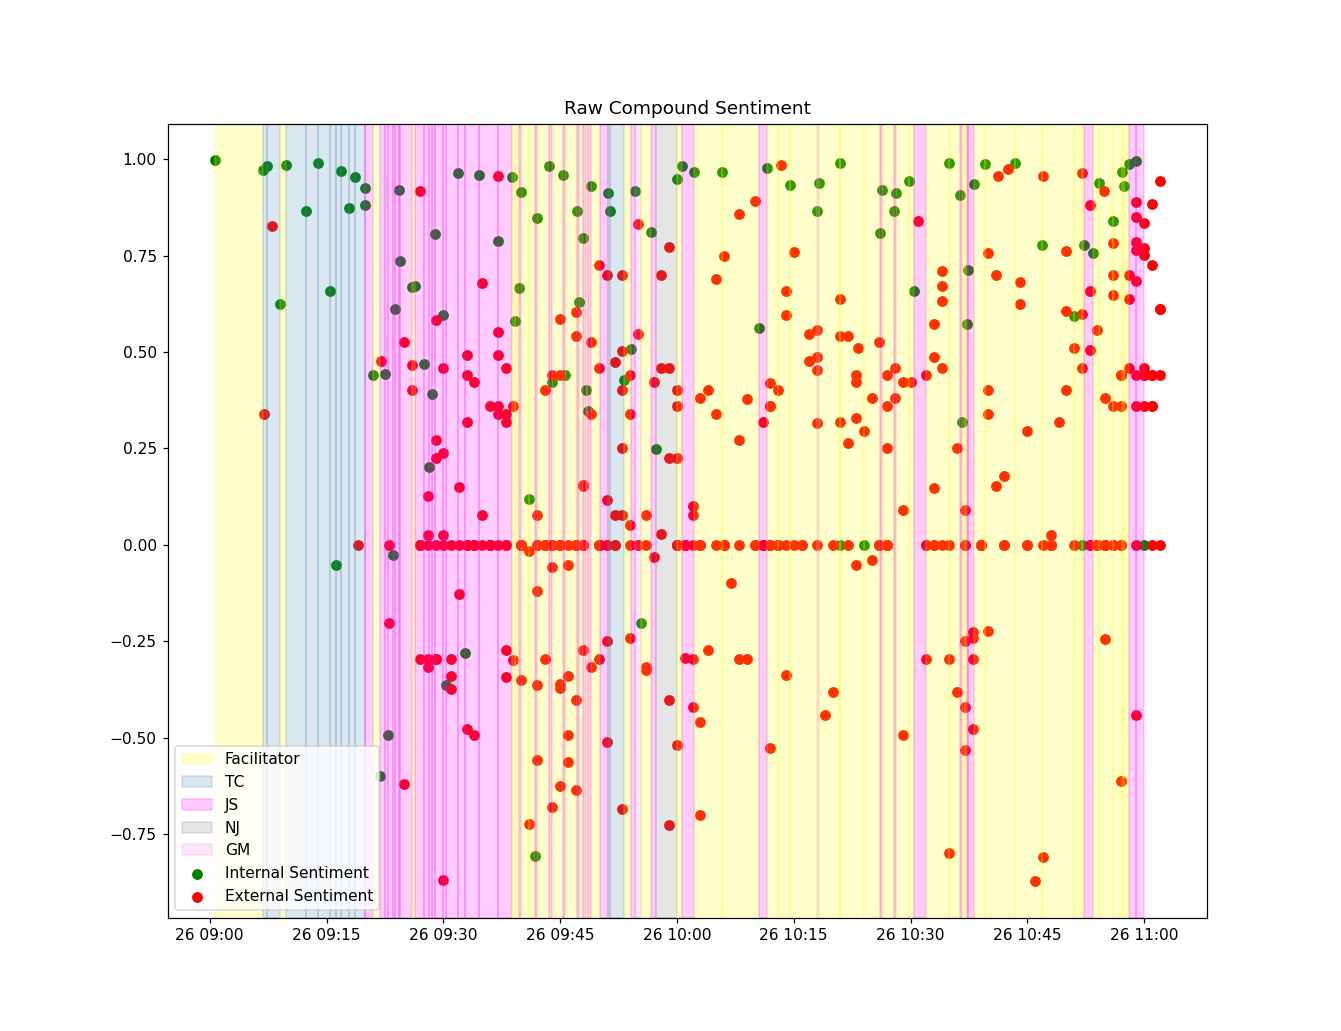

<IPython.core.display.Javascript object>


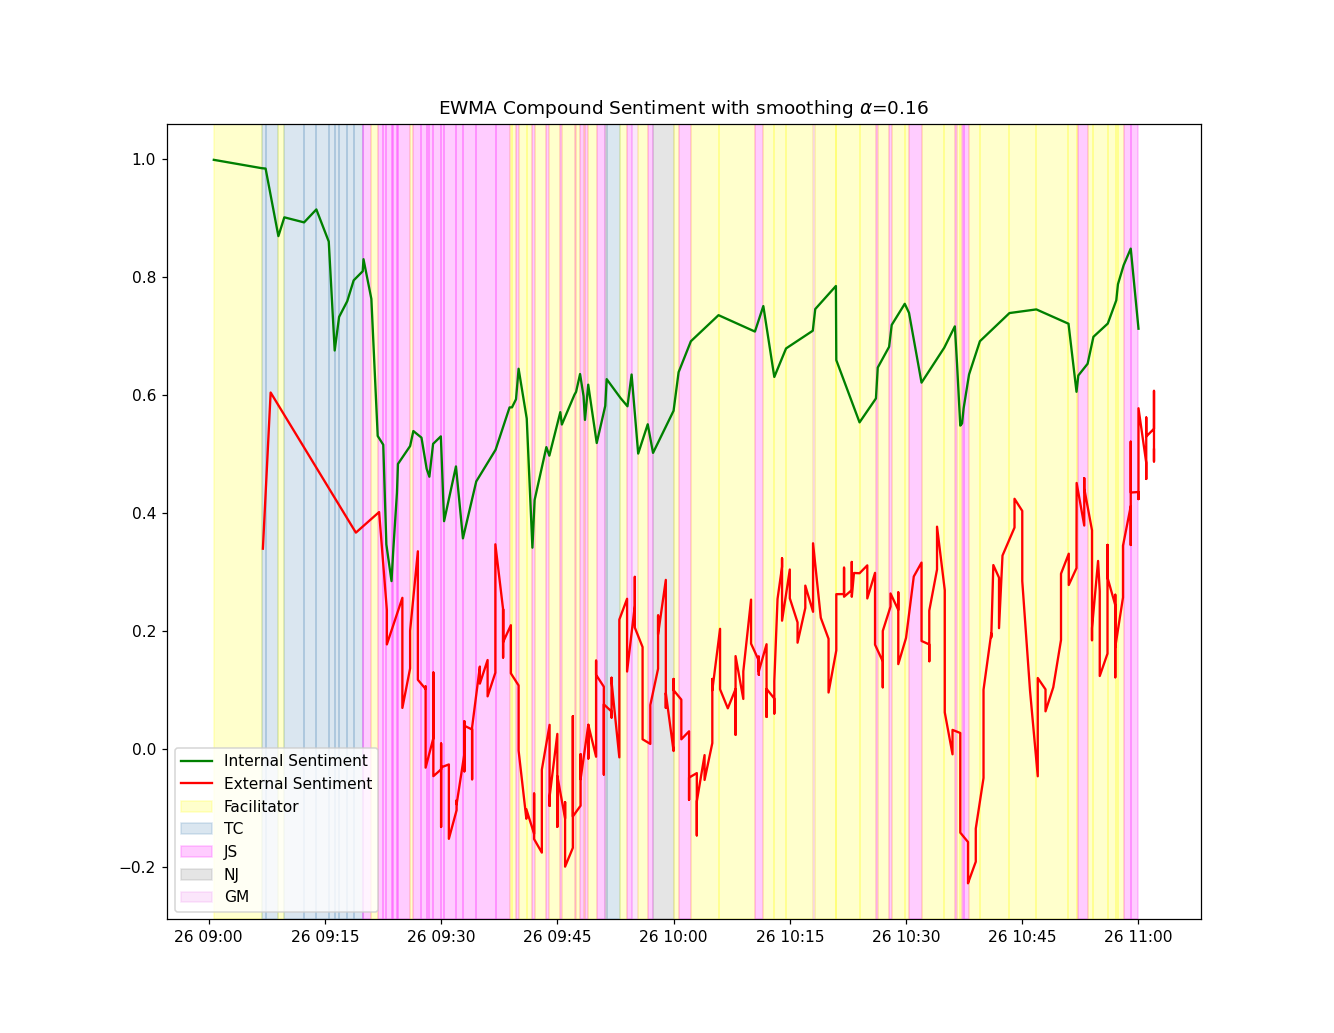

In [115]:
from matplotlib.colors import cnames

sentiment_fig, sax = mpl.subplots(1,1, figsize=(9,8))

int_line = sax.scatter(int_df['time'], int_df['compound_sentiment'], label='Internal Sentiment', color='g')
ext_line = sax.scatter(ext_df['time'], ext_df['compound_sentiment'], label='External Sentiment', color='r')

# 148 colours to choose from!
# Keep rerunning the cell until you win the intelligible plot colours lottery
rand_colour = lambda *args: np.random.choice(list(cnames.keys())) 

author_colours = {} #Cache colours for each author to prevent duplicate legend entries

for idx, (_,row) in enumerate(int_df.iterrows()):
    # Prevent OOB as we look one ahead of the current row on every iteration
    if idx < len(int_df) - 1:
        author = row['author'] # We want the author that is currently speaking in this time period
        author_start = row['time']
        author_stop = int_df.iloc[idx+1]['time']
        label = author
        colour = rand_colour()
        if author not in author_colours:
            author_colours[author] = colour
        else:
            label = '_' #Prevent duplicate legend entries as each axvspan is its own artist
            colour = author_colours[author]
        _ = sax.axvspan(author_start, author_stop, alpha=0.2, color=colour, label=label)
#         print(f'{author} speaking between {author_start} and {author_stop}')

# Prevent these outputting objects by discarding
_ = sax.set_title('Raw Compound Sentiment')
_ = sax.legend()

sentiment_fig.show()

#### Repeat for EWMA values

msentiment_fig, msax = mpl.subplots(1,1, figsize=(9,8))

int_mline = msax.plot(int_df['time'], int_df['cs_ewma'], label='Internal Sentiment', color='g')
ext_mline = msax.plot(ext_df['time'], ext_df['cs_ewma'], label='External Sentiment', color='r')

mauthor_colours = {} #Cache colours for each author to prevent duplicate legend entries

for idx, (_,row) in enumerate(int_df.iterrows()):
    # Prevent OOB as we look one ahead of the current row on every iteration
    if idx < len(int_df) - 1:
        author = row['author'] # We want the author that is currently speaking in this time period
        author_start = row['time']
        author_stop = int_df.iloc[idx+1]['time']
        label = author
        colour = author_colours[author]
        if author not in mauthor_colours:
            mauthor_colours[author] = colour
        else:
            label = '_' #Prevent duplicate legend entries as each axvspan is its own artist
            colour = author_colours[author]
        _ = msax.axvspan(author_start, author_stop, alpha=0.2, color=colour, label=label)
#         print(f'{author} speaking between {author_start} and {author_stop}')

# Prevent these outputting objects by discarding
_ = msax.set_title(f'EWMA Compound Sentiment with smoothing $\\alpha$={ewma_smoothing}')
_ = msax.legend()

msentiment_fig.show()

In [23]:
cs_int_df = int_df.sort_values('compound_sentiment')
cs_ext_df = ext_df.sort_values('compound_sentiment')

print('Most Positive internal messages: ')
cs_int_df['message'].tail(10)
print('\n=================================\n')
print('Most Negative internal messages: ')
cs_int_df['message'].head(8)
print('\n\n=================================\n\n')
print('Most Positive external messages: ')
cs_ext_df['message'].tail(10)
print('\n=================================\n')
print('Most Negative external messages: ')
cs_ext_df['message'].head(10)

Most Positive internal messages: 


C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2     Next slide, please. So, my name is Tom Cherret...
3     Next slide, please. Just to introduce you to t...
81     OK, brilliant.  There's even some resources b...
95     So I think,  and Janet, that perhaps if you c...
5     Next slide, please.So there's a little animati...
84     I'm going to interject quickly just to time  ...
67    So I'm going to kick off by, first of all, ask...
79    And here we are asking, do you see any potenti...
96     Just a big thank you to everyone.  Really gre...
0      Welcome everybody. We are just waiting for so...
Name: message, dtype: object



Most Negative internal messages: 


36     Yeah. This is a this is actually quite comple...
13    Next point, please. I think the low hanging fr...
15    Next point.  I think it's overkill for low ris...
26    So can we just advance the slides for one clic...
28    Next slide, please. For the Ultra Drone, it's ...
54     Thank you. So I will. We will take its field,...
7     Next slide pleaseThe next area of interest is ...
16    next point. And for logistics operations, it's...
Name: message, dtype: object





Most Positive external messages: 


218    [Microlight Pilot 7] -great question on how dr...
91      Can I make a plea?Yes  Plea for those pilots ...
14     @GA Pilot 18: yes, but who certifies that the ...
410    As Chair of the Local to Ipswich LAA Club the ...
82      Firstly, thank you very much indeed for setti...
66     While we all, I'm sure, understand and sympath...
336    A healthy UK aviation industry is good for all...
87      Yeah. Thanks very much. Let's say you're just...
83      I'm just wondering if you have got a timeline...
63      SkyPorts. No, I appreciate that there are goo...
Name: message, dtype: object



Most Negative external messages: 


333    [Drone User 7]  I agree with your sentiment. I...
32     Experience so far with Skyports in Scotland ha...
334    [Microlight Pilot 7] Iâ€™m an AI researcher, b...
301    Drones can bring benefits but the current just...
176    Its a case of avoiding areas of increased bird...
81     TMZ without a service is even worse because it...
195    The range of craft and equipment in GA is anal...
150    My old gliding instructor passed away in a col...
100    VHF / 30 Secs - will block the frequency for o...
122    Has this concept, Class L, been introduced to ...
Name: message, dtype: object

## Topic Modelling

In [24]:
int_tokens = list(int_df['tokens'].explode())
ext_tokens = list(ext_df['tokens'].explode())

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
import gensim
dictionary = gensim.corpora.Dictionary(clean_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in clean_df['tokens']]
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=25)
topics = lda.print_topics(num_words=4)
for topic in topics:
    print(topic)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.021*"drone" + 0.010*"avoid" + 0.010*"community" + 0.010*"aircraft"')
(1, '0.021*"drone" + 0.012*"class" + 0.011*"lima" + 0.011*"tda"')
(2, '0.026*"pilot" + 0.026*"drone" + 0.024*"airspace" + 0.021*"class"')
(3, '0.026*"drone" + 0.025*"airspace" + 0.011*"issue" + 0.011*"aircraft"')
(4, '0.023*"class" + 0.019*"drone" + 0.010*"lima" + 0.008*"tmz"')


In [26]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
